In [1]:
import numpy as np
import torch
from torch import nn
import pickle as pkl
import torch

from torch.optim import lr_scheduler
import torch.optim as optim

import os
import numpy as np
from networks import EmbeddingNet, TripletNetAdapted, TripletNetAdaptedText
from flickrDataSet import *
from matplotlib import pyplot as plt

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = 'TripletNet_taskB.pth'

In [3]:
def aggregation_text(word_embs, axis = 0):
    return np.sum(word_embs, axis=axis)

In [6]:
img_emb_dim = 4096
text_emb_dim = 300

embedding_net_img = EmbeddingNet(emd_dim=img_emb_dim)
embedding_net_text = EmbeddingNet(emd_dim=text_emb_dim)
# model = TripletNetAdapted(embedding_net_img, embedding_net_text)
model = TripletNetAdaptedText(embedding_net_img, embedding_net_text)


print('Loading model...')
model.load_state_dict(torch.load(model_path))
model.to(device)


Loading model...


RuntimeError: Error(s) in loading state_dict for TripletNetAdaptedText:
	Missing key(s) in state_dict: "image_net.fc1.2.weight", "image_net.fc1.2.bias", "text_net.fc1.2.weight", "text_net.fc1.2.bias". 
	Unexpected key(s) in state_dict: "image_net.fc1.1.weight", "text_net.fc1.1.weight". 

In [6]:
# Prepare the dataset
train_data = FlickrDataset('./dataset/train_img_embs.pkl', './dataset/train_text_embs.pkl', aggregation=aggregation_text, train= True)
# test_data = FlickrDataset('./dataset/test_img_embs.pkl', './dataset/test_text_embs.pkl', aggregation=aggregation_text, train= False)

(30014, 5)


In [7]:
color = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
encoded_imgs = []
encoded_captions = []
all_embs = []
labels = []

for ind in range(len(train_data)):
    img, texts = train_data.getAllCaptions(ind)
    img_emb = model.get_embedding_img(torch.from_numpy(img).to(device)).data.cpu().numpy()
    encoded_imgs.append(img_emb)
    texts_embs = [model.get_embedding_text(torch.from_numpy(tx).to(device)).data.cpu().numpy() for tx in texts]
    encoded_captions.append(texts_embs)
    all_embs.append(img_emb)
    all_embs += texts_embs
    labels += [ind for i in range(1 + len(texts_embs))]

encoded_imgs = np.array(encoded_imgs)
encoded_captions = np.array(encoded_captions)

/home/group05/anaconda3/envs/M5env/lib/python3.7/site-packages/scipy/sparse/_index.py:125: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


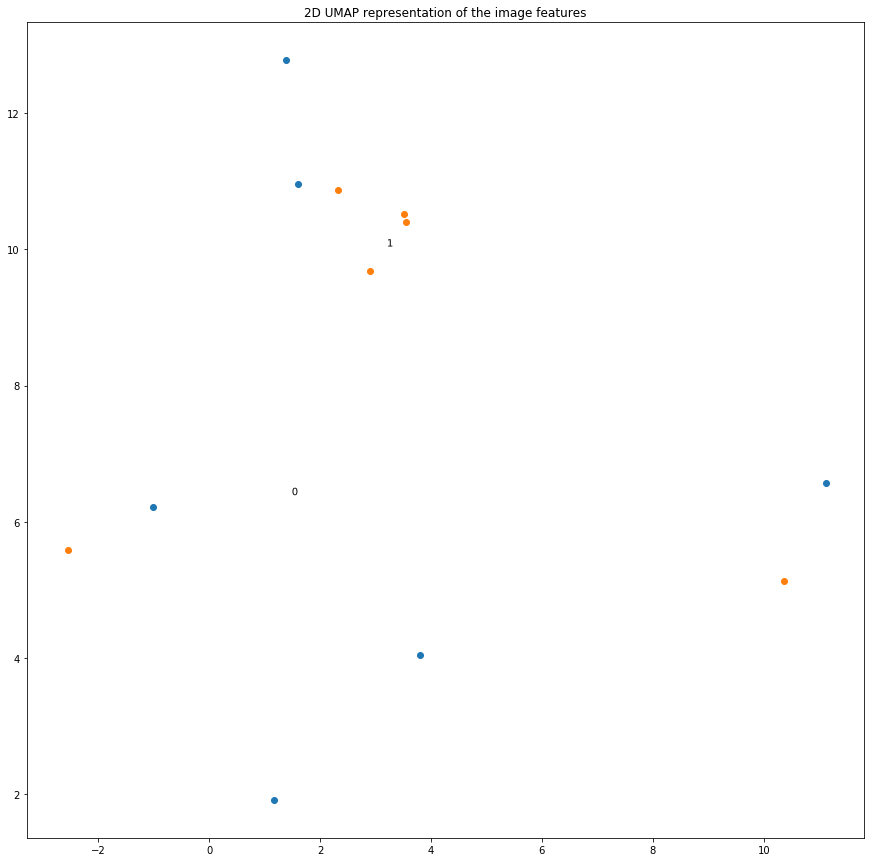

In [9]:
# #UMAP
# # compute the umap image representation
import umap.umap_ as umap
import matplotlib.patheffects as PathEffects

def plot_embeddings_umap(embeddings_cl, embeddings_to_plot, labels_cl):
        plt.figure(figsize=(15,15))
        umap_emb = umap.UMAP(n_neighbors=4, min_dist=0.3, metric='correlation')
        umap_emb.fit(embeddings_cl)
        embedding = umap_emb.transform(embeddings_to_plot)
        labels = np.unique(labels_cl)

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            plt.scatter(
                [x[0] for x in label_features],
                [x[1] for x in label_features],
                c=np.array([color[idx]]),
                label=label,
                # s=np.ones(len(test_classes)),
            )

        # plt.legend(loc='best')

        for idx, label in enumerate(labels):
            label_features = [embedding[i] for i, x in enumerate(labels_cl) if x == label]
            xtext, ytext = np.median(label_features, axis=0)
            txt = plt.text(xtext, ytext, label)
            txt.set_path_effects([
                PathEffects.Stroke(linewidth=5, foreground="w"),
                PathEffects.Normal()])

        plt.title('2D UMAP representation of the image features')
        plt.show()


plot_embeddings_umap(all_embs, all_embs[:12], labels[:12])